In [1]:
# import string # used for preprocessing
# import re # used for preprocessingq

from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, BooleanType, DateType, FloatType
from pyspark.sql import functions as F
from pyspark.sql.functions import *


import numpy as np
import pandas as pd # our main data management package
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt


# EDA

In [2]:
df=spark.read.parquet('gs://buck_561/divvy15_21/all1.parquet')

In [3]:
df.show(2),df.count()

+----------------+-------------------+-------------------+------+------------+---------------+-----------------+-------------+---------------+--------+------+---------+
|         trip_id|          starttime|           stoptime|bikeid|tripduration|from_station_id|from_station_name|to_station_id|to_station_name|usertype|gender|birthyear|
+----------------+-------------------+-------------------+------+------------+---------------+-----------------+-------------+---------------+--------+------+---------+
|99FEC93BA843FB20|2021-06-13 02:31:28|2021-06-13 02:34:11|  null|       163.0|           null|             null|         null|           null|  member|  null|     null|
|06048DCFC8520CAF|2021-06-04 11:18:02|2021-06-04 11:24:19|  null|       377.0|           null|             null|         null|           null|  member|  null|     null|
+----------------+-------------------+-------------------+------+------------+---------------+-----------------+-------------+---------------+--------+----

(None, 30599469)

In [4]:
df.printSchema()

root
 |-- trip_id: string (nullable = true)
 |-- starttime: timestamp (nullable = true)
 |-- stoptime: timestamp (nullable = true)
 |-- bikeid: string (nullable = true)
 |-- tripduration: float (nullable = true)
 |-- from_station_id: string (nullable = true)
 |-- from_station_name: string (nullable = true)
 |-- to_station_id: string (nullable = true)
 |-- to_station_name: string (nullable = true)
 |-- usertype: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- birthyear: string (nullable = true)



In [5]:
print(df.filter('bikeid ="null"').count(),\
      df.filter('gender ="null"').count(),\
      df.filter('birthyear ="null"').count(),\
      df.filter('from_station_name is null').count(),\
      df.filter('to_station_name is null').count(),\
      df.filter('from_station_id is null').count(),\
      df.filter('to_station_id is null').count())

9356125 9356125 9356125 820305 888333 820928 888794


In [6]:
print(df\
      .filter('bikeid !="null"')\
      .filter('from_station_name is null').count(),\
      df\
      .filter('bikeid !="null"')\
      .filter('to_station_name is null').count(),\
      df\
      .filter('bikeid !="null"')\
      .filter('from_station_id is null').count(),\
      df\
      .filter('bikeid !="null"')\
      .filter('to_station_id is null').count())

0 0 0 0


In [7]:
df1=df.filter('bikeid !="null"')

In [8]:
df1.groupby(F.year(F.col('starttime'))).count().orderBy('year(starttime)').show()

+---------------+-------+
|year(starttime)|  count|
+---------------+-------+
|           2013| 759788|
|           2014|2454634|
|           2015|3183439|
|           2016|3595383|
|           2017|3829014|
|           2018|3603082|
|           2019|3818004|
+---------------+-------+



In [9]:
df1.groupby(F.month(F.col('starttime'))).count().orderBy('month(starttime)').show()

+----------------+-------+
|month(starttime)|  count|
+----------------+-------+
|               1| 502113|
|               2| 546824|
|               3| 856701|
|               4|1300423|
|               5|2058475|
|               6|2682710|
|               7|3204171|
|               8|3220756|
|               9|2792652|
|              10|2149544|
|              11|1173773|
|              12| 755202|
+----------------+-------+



In [10]:
df1.groupby(F.weekofyear(F.col('starttime'))).count().orderBy('weekofyear(starttime)').show()

+---------------------+------+
|weekofyear(starttime)| count|
+---------------------+------+
|                    1| 99917|
|                    2|105861|
|                    3|125104|
|                    4|131798|
|                    5|113159|
|                    6|102452|
|                    7|156595|
|                    8|148157|
|                    9|149449|
|                   10|169013|
|                   11|210414|
|                   12|214804|
|                   13|203856|
|                   14|233292|
|                   15|321692|
|                   16|351475|
|                   17|315142|
|                   18|380900|
|                   19|384680|
|                   20|452081|
+---------------------+------+
only showing top 20 rows



In [11]:
df1.groupby(F.hour(F.col('starttime'))).count().orderBy('hour(starttime)').show()

+---------------+-------+
|hour(starttime)|  count|
+---------------+-------+
|              0|1378387|
|              1|1331744|
|              2|1282182|
|              3|1442423|
|              4|2041047|
|              5|2691846|
|              6|2278067|
|              7|2391153|
|              8|2375257|
|              9|1469469|
|             10|1245446|
|             11|1316323|
+---------------+-------+



In [12]:
df1.groupby(F.dayofweek(F.col('starttime'))).count().orderBy('dayofweek(starttime)').show()

+--------------------+-------+
|dayofweek(starttime)|  count|
+--------------------+-------+
|                   1|2700835|
|                   2|3114545|
|                   3|3164482|
|                   4|3087614|
|                   5|3100497|
|                   6|3126189|
|                   7|2949182|
+--------------------+-------+



In [13]:
df1.groupby(F.dayofmonth(F.col('starttime'))).count().orderBy('dayofmonth(starttime)').show(31)

+---------------------+------+
|dayofmonth(starttime)| count|
+---------------------+------+
|                    1|668007|
|                    2|696735|
|                    3|719918|
|                    4|700744|
|                    5|713017|
|                    6|708251|
|                    7|697290|
|                    8|726061|
|                    9|704700|
|                   10|680133|
|                   11|692702|
|                   12|655548|
|                   13|694126|
|                   14|688979|
|                   15|689925|
|                   16|726221|
|                   17|711425|
|                   18|724462|
|                   19|720208|
|                   20|689560|
|                   21|688668|
|                   22|702520|
|                   23|706324|
|                   24|692976|
|                   25|713114|
|                   26|684873|
|                   27|684829|
|                   28|672672|
|                   29|652848|
|       

In [14]:
expr=[]\
+["case when tripduration < 0 then '<0' \
when tripduration >=0 and tripduration <600 then '0-600' \
when tripduration >=600 and tripduration <1200 then '600-1200' \
when tripduration >=1200 and tripduration <1800 then '1200-1800' \
when tripduration >=1800 and tripduration <2400 then '1800-2400' \
when tripduration >=2400 and tripduration <3000 then '2400-3000' \
when tripduration >=3000 and tripduration <3600 then '3000-3600' \
when tripduration >=3600 and tripduration <7200 then '3600-7200'\
when tripduration >=7200 and tripduration <10800 then '7200-10800'\
when tripduration >=10800 and tripduration <14400 then '10800-14400'\
else '>14400' end as durbuck "]

df1.selectExpr(["*"]+expr).groupBy('durbuck').count().orderBy('count').show()

+-----------+-------+
|    durbuck|  count|
+-----------+-------+
|10800-14400|  23818|
|     >14400|  39269|
| 7200-10800|  98700|
|  3000-3600| 228947|
|  2400-3000| 389272|
|  3600-7200| 444944|
|  1800-2400| 965563|
|  1200-1800|3198197|
|   600-1200|6926752|
|      0-600|8927882|
+-----------+-------+



In [15]:
expr=[]\
+["case when tripduration < 0 then -1 when tripduration >=0 and tripduration <600 then 599 when tripduration >=600 and tripduration <1200 then 1199 when tripduration >=1200 and tripduration <1800 then 1799 when tripduration >=1800 and tripduration <2400 then 2399 when tripduration >=2400 and tripduration <3000 then 2999 when tripduration >=3000 and tripduration <3600 then 3599 when tripduration >=3600 and tripduration <7200 then 7199 when tripduration >=7200 and tripduration <10800 then 10799 when tripduration >=10800 and tripduration <14400 then 14399 else 14401 end as durbuck "]

df1.selectExpr(["*"]+expr).groupBy('durbuck').count().orderBy('count').show(),df1.selectExpr(["*"]+expr).groupBy('durbuck').count().orderBy('durbuck').show()

+-------+-------+
|durbuck|  count|
+-------+-------+
|  14399|  23818|
|  14401|  39269|
|  10799|  98700|
|   3599| 228947|
|   2999| 389272|
|   7199| 444944|
|   2399| 965563|
|   1799|3198197|
|   1199|6926752|
|    599|8927882|
+-------+-------+



+-------+-------+
|durbuck|  count|
+-------+-------+
|    599|8927882|
|   1199|6926752|
|   1799|3198197|
|   2399| 965563|
|   2999| 389272|
|   3599| 228947|
|   7199| 444944|
|  10799|  98700|
|  14399|  23818|
|  14401|  39269|
+-------+-------+



(None, None)

In [16]:
df2=df1.filter('tripduration <=7200')
df2.count()

21081620

In [17]:
df2.groupBy('from_station_name').count().orderBy('count',ascending=False).show(20,False)

+-----------------------------------+------+
|from_station_name                  |count |
+-----------------------------------+------+
|Streeter Dr & Grand Ave            |316088|
|Lake Shore Dr & Monroe St          |291194|
|Clinton St & Washington Blvd       |284685|
|Canal St & Adams St                |274100|
|Theater on the Lake                |246793|
|Clinton St & Madison St            |241774|
|Lake Shore Dr & North Blvd         |229226|
|Michigan Ave & Oak St              |224032|
|Millennium Park                    |219837|
|Canal St & Madison St              |203806|
|Columbus Dr & Randolph St          |196734|
|Michigan Ave & Washington St       |189822|
|Daley Center Plaza                 |167413|
|Kingsbury St & Kinzie St           |153541|
|McClurg Ct & Illinois St           |147385|
|LaSalle St & Jackson Blvd          |144975|
|Michigan Ave & Lake St             |144252|
|Franklin St & Monroe St            |143417|
|Clark St & Elm St                  |140011|
|Orleans S

In [18]:
df2.groupBy('to_station_name').count().orderBy('count',ascending=False).show(20,False)

+----------------------------+------+
|to_station_name             |count |
+----------------------------+------+
|Streeter Dr & Grand Ave     |357542|
|Clinton St & Washington Blvd|280366|
|Lake Shore Dr & Monroe St   |269302|
|Theater on the Lake         |265417|
|Canal St & Adams St         |264124|
|Lake Shore Dr & North Blvd  |261188|
|Millennium Park             |242805|
|Michigan Ave & Oak St       |240008|
|Clinton St & Madison St     |231612|
|Canal St & Madison St       |209009|
|Michigan Ave & Washington St|196850|
|Daley Center Plaza          |162687|
|Streeter Dr & Illinois St   |162613|
|Kingsbury St & Kinzie St    |152438|
|McClurg Ct & Illinois St    |147425|
|Michigan Ave & Lake St      |146134|
|Clark St & Elm St           |144521|
|Wabash Ave & Grand Ave      |137664|
|LaSalle St & Jackson Blvd   |136802|
|Wabash Ave & Roosevelt Rd   |135679|
+----------------------------+------+
only showing top 20 rows



In [19]:
df2.groupBy('from_station_name','to_station_name').count().orderBy('count',ascending=False).show(20,False)

+----------------------------+----------------------------+-----+
|from_station_name           |to_station_name             |count|
+----------------------------+----------------------------+-----+
|Lake Shore Dr & Monroe St   |Streeter Dr & Grand Ave     |40503|
|Lake Shore Dr & Monroe St   |Lake Shore Dr & Monroe St   |37658|
|Streeter Dr & Grand Ave     |Streeter Dr & Grand Ave     |34110|
|Michigan Ave & Oak St       |Michigan Ave & Oak St       |25694|
|Streeter Dr & Grand Ave     |Theater on the Lake         |22178|
|Streeter Dr & Grand Ave     |Lake Shore Dr & North Blvd  |20790|
|Theater on the Lake         |Streeter Dr & Grand Ave     |19963|
|Streeter Dr & Grand Ave     |Lake Shore Dr & Monroe St   |19822|
|Lake Shore Dr & Monroe St   |Streeter Dr & Illinois St   |19651|
|Lake Shore Dr & North Blvd  |Streeter Dr & Grand Ave     |19338|
|Michigan Ave & Oak St       |Theater on the Lake         |17806|
|Theater on the Lake         |Theater on the Lake         |17626|
|Millenniu

In [20]:
df2.select('from_station_name').distinct().count()

749

.

# aggregated data

In [ ]:
# .withColumn('week',F.weekofyear('starttime'))\

In [3]:
df=spark.read.parquet('gs://buck_561/divvy15_21/all1.parquet')
df1=df.filter('bikeid !="null"').filter('tripduration <=7200')
df2=df1.withColumn('hr',F.hour('starttime'))\
.withColumn('year',F.year('starttime'))\
.withColumn('month',F.month('starttime'))\
.withColumn('day',F.dayofmonth('starttime'))\
.groupBy('year','month','day','hr','from_station_id')\
.agg(F.count('trip_id').alias('count'))\
.orderBy('hr',ascending=False)


In [5]:
df2.write.mode('overwrite').parquet('gs://buck_561/divvy15_21/all2.parquet')

.

# feature engineering

In [21]:
df4=spark.read.parquet('gs://buck_561/divvy15_21/all2.parquet')
df4.show(5)

+----+-----+---+---+---------------+-----+
|year|month|day| hr|from_station_id|count|
+----+-----+---+---+---------------+-----+
|2019|   10|  4|  8|            479|    1|
|2019|   10|  5|  8|            652|    1|
|2019|   10|  6|  8|            306|    2|
|2019|   10|  7|  8|            213|    6|
|2019|   10|  7|  8|             13|   11|
+----+-----+---+---+---------------+-----+
only showing top 5 rows



In [22]:
whr  = Window.partitionBy("from_station_id").orderBy("year","month","day","hr")
wday  = Window.partitionBy("hr","from_station_id").orderBy("year","month","day")
wmn  = Window.partitionBy("day","hr","from_station_id").orderBy("year","month")
wyr  = Window.partitionBy("month","day","hr","from_station_id").orderBy("year")


In [23]:
df4=df4.withColumn('rank',F.dense_rank().over(whr))\
.withColumn('lasthr1',F.lag(F.col('count'),1).over(whr))\
.withColumn('lasthr2',F.lag(F.col('count'),2).over(whr))\
.withColumn('lastday1',F.lag(F.col('count'),1).over(wday))\
.withColumn('lastday2',F.lag(F.col('count'),2).over(wday))\
.withColumn('lastmn1',F.lag(F.col('count'),1).over(wmn))\
.withColumn('lastmn2',F.lag(F.col('count'),2).over(wmn))\
.withColumn('lastyr1',F.lag(F.col('count'),1).over(wyr))\
.withColumn('lastyr2',F.lag(F.col('count'),2).over(wyr))\
.na.fill(0)


df4.select("from_station_id","year","month","day","hr","count","rank","lasthr1","lasthr2","lastday1","lastday2","lastmn1","lastmn2","lastyr1","lastyr2").orderBy('from_station_id','year','month','day','hr').show()

+---------------+----+-----+---+---+-----+----+-------+-------+--------+--------+-------+-------+-------+-------+
|from_station_id|year|month|day| hr|count|rank|lasthr1|lasthr2|lastday1|lastday2|lastmn1|lastmn2|lastyr1|lastyr2|
+---------------+----+-----+---+---+-----+----+-------+-------+--------+--------+-------+-------+-------+-------+
|              1|2019|    5| 21|  2|    1|   1|      0|      0|       0|       0|      0|      0|      0|      0|
|            100|2013|    7| 17|  0|    2|   1|      0|      0|       0|       0|      0|      0|      0|      0|
|            100|2013|    7| 17|  1|    1|   2|      2|      0|       0|       0|      0|      0|      0|      0|
|            100|2013|    7| 17|  4|    1|   3|      1|      2|       0|       0|      0|      0|      0|      0|
|            100|2013|    7| 17|  5|    2|   4|      1|      1|       0|       0|      0|      0|      0|      0|
|            100|2013|    7| 17|  6|    1|   5|      2|      1|       0|       0|      0

In [24]:
df4.filter('year=2016').filter('month=1').filter('day=1').select("from_station_id","year","month","day","hr","count","rank","lasthr1","lasthr2","lastday1","lastday2","lastmn1","lastmn2","lastyr1","lastyr2").orderBy('from_station_id','year','month','day','hr').show()

+---------------+----+-----+---+---+-----+----+-------+-------+--------+--------+-------+-------+-------+-------+
|from_station_id|year|month|day| hr|count|rank|lasthr1|lasthr2|lastday1|lastday2|lastmn1|lastmn2|lastyr1|lastyr2|
+---------------+----+-----+---+---+-----+----+-------+-------+--------+--------+-------+-------+-------+-------+
|            102|2016|    1|  1|  7|    1| 331|      1|      2|       1|       1|      1|      0|      0|      0|
|            102|2016|    1|  1|  8|    1| 332|      1|      1|       2|       1|      3|      0|      0|      0|
|            106|2016|    1|  1|  3|    1|6869|      2|      1|       3|       1|      2|      2|      0|      0|
|            106|2016|    1|  1|  5|    1|6870|      1|      2|       2|       1|      5|      2|      1|      0|
|            106|2016|    1|  1| 10|    1|6871|      1|      1|       1|       1|      3|      2|      0|      0|
|            107|2016|    1|  1|  1|    1|2328|      3|      2|       1|       2|      4

.

# one hot encoded

In [25]:
# df4=spark.read.parquet('gs://buck_561/divvy15_21/all2.parquet')
#   ##  gather the distinct values
distinct_values = df4.select("from_station_id")\
                    .distinct()\
                    .rdd\
                    .flatMap(lambda x: x).collect()

#   ##  for each of the gathered values create a new column 
for distinct_value in distinct_values:
    function = F.udf(lambda item: 
                   1 if item == distinct_value else 0, 
                   IntegerType())
    new_column_name = "from_station_id"+'_'+distinct_value
    df4 = df4.withColumn(new_column_name, function(col("from_station_id")))

In [ ]:
df4.drop('from_station_id').write.mode('overwrite').parquet('gs://buck_561/divvy15_21/all3.parquet')

.

# to pandas

In [ ]:
df4=spark.read.parquet('gs://buck_561/divvy15_21/all3.parquet')

In [ ]:
for i in range (12):
    a=df4.filter(F.col('month')==(i+1)).filter('day<16').toPandas()
    a.to_csv('gs://buck_561/divvy15_21/'+str(i+1)+'_l16month.csv',index=False)
    print(str(i+1)+" half month done")
    a=df4.filter(F.col('month')==(i+1)).filter('day>15').toPandas()
    a.to_csv('gs://buck_561/divvy15_21/'+str(i+1)+'_g15month.csv',index=False)
    print(str(i+1)+" month done")

1 half month done


1 month done


2 half month done


2 month done


3 half month done


3 month done


4 half month done


4 month done


5 half month done


5 month done


6 half month done


6 month done


7 half month done


7 month done


8 half month done


8 month done


9 half month done


9 month done


10 half month done


10 month done


11 half month done


11 month done


12 half month done


12 month done


.

# Modelilng

In [19]:
# df4=spark.read.parquet('gs://buck_561/divvy15_21/all3.parquet')
# df4.show(1)

In [20]:
# df5=df4.filter('year = 2016').filter('month < 4').toPandas()
# df5.shape

In [30]:
df5=pd.read_csv('gs://buck_561/divvy15_21/1_l16month.csv').drop('rank',axis=1)
df5.head()

,year,month,day,hr,count,lasthr1,lasthr2,lastday1,lastday2,lastmn1,...,from_station_id_45,from_station_id_57,from_station_id_332,from_station_id_542,from_station_id_553,from_station_id_216,from_station_id_572,from_station_id_522,from_station_id_119,from_station_id_438
0,2017,1,1,0,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2019,1,1,0,1,1,1,1,2,1,...,0,0,0,0,0,0,0,0,0,0
2,2018,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,2019,1,1,0,1,2,2,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,2017,1,1,0,1,2,1,1,2,2,...,0,0,0,0,0,0,0,0,0,0


In [42]:
X=df5.drop('count',axis=1).values
y=df5['count'].values

.

# Linear Regression

In [43]:
reg = LinearRegression().fit(X, y)

In [44]:
reg.score(X, y)

0.47118353987911965

In [45]:
pred=reg.predict(X)
mean_squared_error(y, pred),mean_absolute_error(y, pred)

(3.2630069200194325, 1.0831815509421028)

In [8]:
# reg.coef_,reg.intercept_

.

# decision tree

In [10]:
# regr_1 = DecisionTreeRegressor(max_depth=2)
# regr_1.fit(X, y)
# y_1 = regr_1.predict(X)
# mean_squared_error(y, y_1)

DecisionTreeRegressor(max_depth=5)

In [46]:
for i in range(8):
    regr_1 = DecisionTreeRegressor(max_depth=i+1)
    regr_1.fit(X, y)
    y_1 = regr_1.predict(X)
    print(str(i+1) + " : "+ str(mean_squared_error(y, y_1)) + " : "+ str(mean_absolute_error(y, y_1)))
    

1 : 4.999766999260414 : 1.3116933129035628
2 : 4.157639800445296 : 1.2232769415599065
3 : 3.763431850061308 : 1.1991967980692555
4 : 3.4582020222823426 : 1.149889136659541
5 : 3.2532393440059217 : 1.1135510333409413
6 : 3.0871354661310204 : 1.0883638986064768
7 : 2.947067716943019 : 1.07319727408876
8 : 2.79565093458767 : 1.0562557273518924


In [19]:
# for i in range(8):
#     regr_1 = DecisionTreeRegressor(max_depth=i+1)
#     regr_1.fit(X, y)
#     y_1 = regr_1.predict(X)
#     print(str(i+1) + " : "+ str(mean_squared_error(y, y_1)) + " : "+ str(mean_absolute_error(y, y_1)))
    

1 : 5.90492420993731 : 1.4107220079880873
2 : 5.6754507001326155 : 1.3963234129300928
3 : 5.365607887266889 : 1.373782181891927
4 : 5.084147748930029 : 1.3501112891530869
5 : 4.90040207000058 : 1.3341925346798793
6 : 4.720706098030479 : 1.3341021995030076
7 : 4.587675541117836 : 1.3176089446457242
8 : 4.366138160584761 : 1.2958592941411347


.

# Random Forest

In [23]:
# regr = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, 
#                              min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, 
#                              oob_score=True, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)
# regr.fit(X, y)
# preds=regr.predict(X)
# mean_squared_error(y, preds)

RandomForestRegressor(max_depth=2, random_state=0)

In [47]:
for i in range(8):
    regr = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=i+1, min_samples_split=2, min_samples_leaf=1, 
                                 min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, 
                                 oob_score=True, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)
    regr.fit(X, y)
    preds = regr.predict(X)
    print(str(i+1) + " : "+ str(mean_squared_error(y, preds)) + " : "+ str(mean_absolute_error(y, preds)))
    

1 : 4.547964223858282 : 1.264362327318768
2 : 3.8860127100643376 : 1.194333121895213
3 : 3.4584829052195745 : 1.1496632182946667
4 : 3.21967057376584 : 1.1201844131727736
5 : 3.0336693718284886 : 1.0943224747323073
6 : 2.8847338728702274 : 1.0716415011557423
7 : 2.7427117674835184 : 1.0540753038930906
8 : 2.5956552309938172 : 1.0372034124186758


In [30]:
# for i in range(8):
#     regr = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=i+1, min_samples_split=2, min_samples_leaf=1, 
#                                  min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, 
#                                  oob_score=True, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)
#     regr.fit(X, y)
#     preds = regr.predict(X)
#     print(str(i+1) + " : "+ str(mean_squared_error(y, preds)) + " : "+ str(mean_absolute_error(y, preds)))
    

1 : 5.904926203942963 : 1.4100245652061612
2 : 5.6701861513384735 : 1.3958251777301076
3 : 5.324601039207655 : 1.370264938629934
4 : 5.036585630963812 : 1.3460981311033753
5 : 4.802267205925031 : 1.3227383694741328
6 : 4.6280216740680356 : 1.3151570354058943
7 : 4.436650697088442 : 1.2954176860787625
8 : 4.2632127763902545 : 1.2809867780112905


.

# GBM

In [ ]:
params = {
    "n_estimators": 100,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01
}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)
reg = GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

In [49]:
mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 3.7743


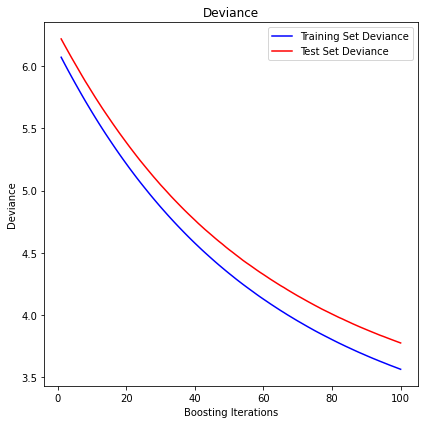

In [51]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance")
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

.